# Packages and modules

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from pmdarima.arima import auto_arima

from models.tsnormalization import TimeNormalization
from utils.preprocessing import convert_dataframe_to_tfdataset, long_term_predict

# Reading data

In [2]:
df = pd.read_csv('../data/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# EDA

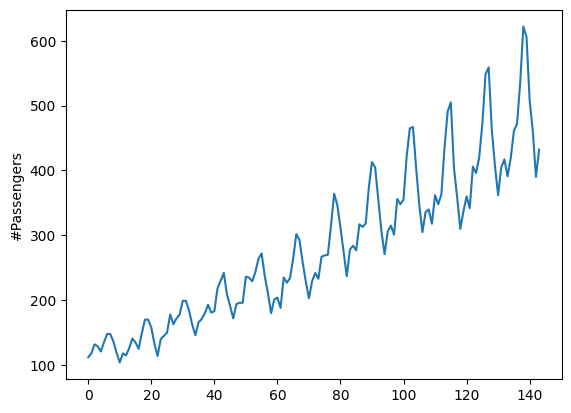

In [3]:
fig, ax = plt.subplots()

sns.lineplot(x=range(len(df)), y='#Passengers', data=df, ax=ax)
plt.show()

# Splitting data into train, validation and test

In [4]:
val_periods = 15
test_periods = 15
df_train = df.iloc[:-(val_periods + test_periods), :]
df_val = df.iloc[-(val_periods + test_periods):-test_periods, :]
df_test = df.iloc[-test_periods:, :]

print(f"{len(df)} = {len(df_train)} + {len(df_val)} + {len(df_test)}")

train_periods = len(df_train)

144 = 114 + 15 + 15


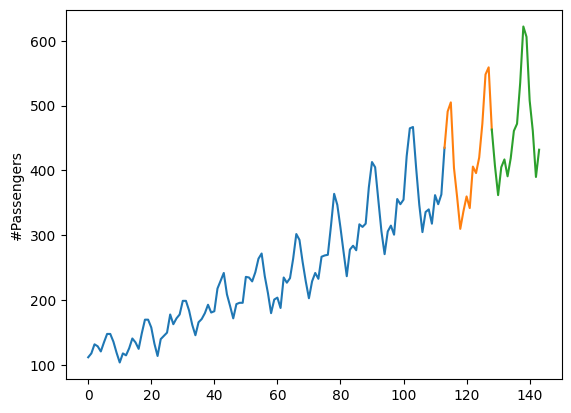

In [5]:
fig, ax = plt.subplots()

sns.lineplot(x=range(train_periods), y='#Passengers', data=df_train, ax=ax)
sns.lineplot(x=range(train_periods - 1, train_periods + val_periods), y='#Passengers', data=pd.concat([df_train.tail(1), df_val]), ax=ax)
sns.lineplot(
    x=range(
    train_periods + val_periods - 1, train_periods + val_periods + test_periods
    ),
    y='#Passengers',
    data=pd.concat([df_val.tail(1), df_test]),
    ax=ax
)
plt.show()

# Creating tensorflow datasets

In [29]:
periods = 14
buffer_size = 10000
batch_size = 16

dataset = convert_dataframe_to_tfdataset(df, periods=periods)
train_val_dataset = dataset.take(train_periods + val_periods - periods)
train_dataset = train_val_dataset.take(train_periods - periods).repeat().shuffle(buffer_size).batch(batch_size)
val_dataset = train_val_dataset.skip(val_periods).batch(1000).cache()

# LSTM model

In [30]:
input_layer = tf.keras.layers.Input(shape=[periods, 1])
x, mean, std = TimeNormalization()(input_layer)
x = tf.keras.layers.LSTM(
    units=100,
    return_sequences=True,
    activation='tanh'
)(x)
x = tf.keras.layers.LSTM(
    units=50,
    return_sequences=True,
    activation='tanh'
)(x)
x = tf.keras.layers.LSTM(
    units=25,
    return_sequences=False,
    activation='tanh'
)(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(units=1, activation='linear')(x)
output = std * x + mean

model = tf.keras.Model(input_layer, output)

model.compile(loss='mae', optimizer='adam')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
history = model.fit(
    train_dataset,
    epochs=1000,
    steps_per_epoch=100,
    callbacks=[early_stopping],
    validation_data=val_dataset,
    verbose=0
)

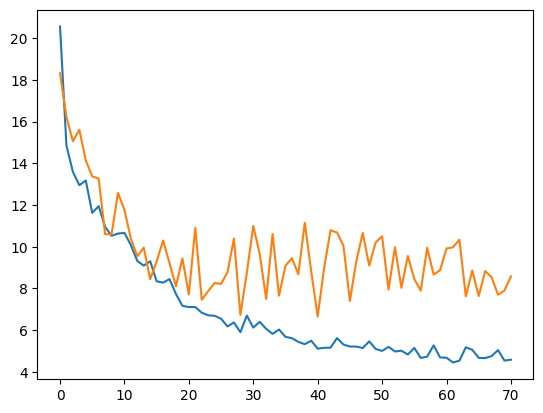

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# ARIMA model

In [32]:
arima_model = auto_arima(
    df_train['#Passengers'], start_p=0, d=1, start_q=0,
    max_p=5, max_d=5, max_q=5,
    start_P=0, D=1, start_Q=0,
    max_P=5, max_D=5, max_Q=5, m=12,
    seasonal=True, error_action='warn', trace=True,
    suppress_warnings=True, stepwise=True,
    random_state=42, n_fits=500
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=749.666, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=746.994, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=747.670, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=746.999, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=748.475, Time=0.19 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=748.774, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=747.301, Time=0.11 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=748.578, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=748.460, Time=0.10 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=747.923, Time=0.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=747.379, Time=0.08 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=749.897, Time=0.21 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=748.975, Time=0.15 sec

Best model:  ARIMA(1,1,0)(1,1,0)[12]

In [33]:
arima_model.aic()

746.9937366820234

# Predict

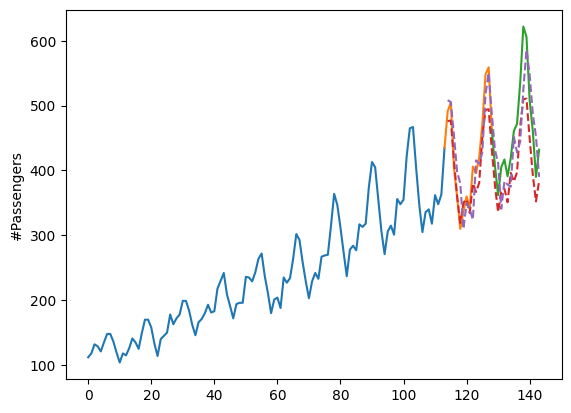

In [34]:
initial_data = tf.cast(tf.reshape(df_train.tail(periods)['#Passengers'].tolist(), [1, periods, 1]), tf.float32)
new_data_lstm = long_term_predict(model, initial_data, timesteps=val_periods + test_periods)

new_data_arima = arima_model.predict(n_periods=val_periods + test_periods)
fig, ax = plt.subplots()

sns.lineplot(x=range(train_periods), y='#Passengers', data=df_train, ax=ax)
sns.lineplot(x=range(train_periods - 1, train_periods + val_periods), y='#Passengers', data=pd.concat([df_train.tail(1), df_val]), ax=ax)
sns.lineplot(
    x=range(
    train_periods + val_periods - 1, train_periods + val_periods + test_periods
    ),
    y='#Passengers',
    data=pd.concat([df_val.tail(1), df_test]),
    ax=ax
)
sns.lineplot(
    x=range(train_periods, train_periods + val_periods + test_periods),
    y=new_data_arima,
    linestyle='dashed',
    ax=ax
)
sns.lineplot(
    x=range(train_periods, train_periods + val_periods + test_periods),
    y=new_data_lstm[0, :, 0],
    linestyle='dashed',
    ax=ax
)
plt.show()

In [106]:
train_samples = train_val_dataset.take(train_periods - periods).map(lambda x, y: x).batch(1000)
lstm_train_predictions = model.predict(train_samples)[:,0]
arima_train_predictions = arima_model.fittedvalues().values[-(train_periods - periods):]

1/1 [==============================] - 0s 43ms/step


In [113]:
real_train_values = next(train_val_dataset.take(train_periods - periods).map(lambda x, y: y).batch(1000).as_numpy_iterator())[:, 0]

In [121]:
X = np.concatenate([lstm_train_predictions.reshape([100, 1]), arima_train_predictions.reshape([100, 1])], axis=1)

In [144]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [0, .1, 1, 10, 100]})
grid_search.fit(X=X, y=real_train_values)

GridSearchCV(estimator=Ridge(), param_grid={'alpha': [0, 0.1, 1, 10, 100]})

In [146]:
linear_regressor = grid_search.best_estimator_

In [157]:
X = np.concatenate(
    [new_data_lstm.numpy().squeeze(axis=0), new_data_arima.values.reshape([30, 1])],
    axis=1
)

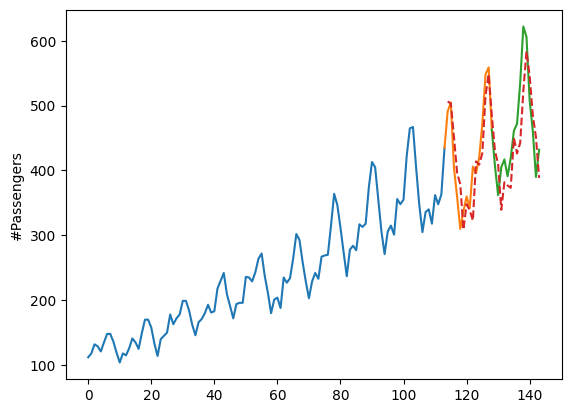

In [159]:
fig, ax = plt.subplots()

sns.lineplot(x=range(train_periods), y='#Passengers', data=df_train, ax=ax)
sns.lineplot(x=range(train_periods - 1, train_periods + val_periods), y='#Passengers', data=pd.concat([df_train.tail(1), df_val]), ax=ax)
sns.lineplot(
    x=range(
    train_periods + val_periods - 1, train_periods + val_periods + test_periods
    ),
    y='#Passengers',
    data=pd.concat([df_val.tail(1), df_test]),
    ax=ax
)

sns.lineplot(
    x=range(train_periods, train_periods + val_periods + test_periods),
    y=linear_regressor.predict(X),
    linestyle='dashed',
    ax=ax
)
plt.show()